In [149]:
import torch
from torch import nn
from torch import optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
raw_df = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv')
raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3019 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3019 non-null   float64       
 5   Volume  3019 non-null   int64         
 6   Name    3019 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.2+ KB


In [8]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
train_df = raw_df[raw_df['Date'] < '2017-01-01']
val_df = raw_df[raw_df['Date'] >= '2017-01-01']
train_df.describe()

,Date,Open,High,Low,Close,Volume
count,2768,2768.000000,2768.000000,2768.000000,2768.000000,2.768000e+03
mean,2011-07-03 16:58:05.549132800,381.840824,385.282547,377.966799,381.640795,3.726924e+06
min,2006-01-03 00:00:00,131.390000,134.820000,123.770000,128.850000,5.211410e+05
25%,2008-10-01 18:00:00,242.565000,245.517500,240.380000,242.665000,1.890533e+06
50%,2011-07-03 00:00:00,301.050000,303.960000,298.695000,300.830000,2.681768e+06
75%,2014-04-03 06:00:00,539.482500,543.860000,534.675000,539.520000,4.449337e+06
max,2016-12-30 00:00:00,838.500000,839.000000,829.040000,835.740000,4.118289e+07
std,NaN,185.842872,186.884618,184.531133,185.750929,3.107589e+06


In [11]:
train_price_df = train_df[['High']]
val_price_df = val_df[['High']]
raw_price_df = raw_df[['High']]

In [13]:
sc = MinMaxScaler()

scaled_df = sc.fit_transform(raw_price_df)
scaled_raw_df = scaled_df

scaled_df = sc.fit_transform(train_price_df)
scaled_train_df = scaled_df

scaled_df = sc.fit_transform(val_price_df)
scaled_val_df = scaled_df

In [16]:
def transform_data(stock, lookback):
    data_raw = stock
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    
    x_train = data[:,:-1,:]
    y_train = data[:,-1,:]
    
    
    return [x_train, y_train]

In [17]:
num_hidden = 60
x_train, y_train = transform_data(scaled_train_df, num_hidden)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
x_val, y_val = transform_data(scaled_val_df, num_hidden)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape)

x_train.shape =  (2708, 59, 1)
y_train.shape =  (2708, 1)
x_val.shape =  (191, 59, 1)
y_val.shape =  (191, 1)


In [18]:
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_val_tensor = torch.from_numpy(x_val).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)
y_val_tensor= torch.from_numpy(y_val).type(torch.Tensor)

print("Shape x_train_tensor:", x_train_tensor.shape)
print("Shape y_train_tensor:", y_train_tensor.shape)
print("Shape x_val_tensor:", x_val_tensor.shape)
print("Shape y_val_tensor:", y_val_tensor.shape)

Shape x_train_tensor: torch.Size([2708, 59, 1])
Shape y_train_tensor: torch.Size([2708, 1])
Shape x_val_tensor: torch.Size([191, 59, 1])
Shape y_val_tensor: torch.Size([191, 1])


In [2]:
class LSTM(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = num_hiddens
        self.num_layers = num_layers

        self.lstm = nn.LSTM(num_inputs, num_hiddens, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(num_hiddens, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [4]:
model = LSTM(1, 32, 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [5]:
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [19]:
for epoch in range(50):
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{50}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.202873
Epoch [2/50], Loss: 0.113452
Epoch [3/50], Loss: 0.064486
Epoch [4/50], Loss: 0.122735
Epoch [5/50], Loss: 0.069962
Epoch [6/50], Loss: 0.059976
Epoch [7/50], Loss: 0.064909
Epoch [8/50], Loss: 0.069945
Epoch [9/50], Loss: 0.071627
Epoch [10/50], Loss: 0.069775
Epoch [11/50], Loss: 0.065041
Epoch [12/50], Loss: 0.058254
Epoch [13/50], Loss: 0.050332
Epoch [14/50], Loss: 0.042502
Epoch [15/50], Loss: 0.036821
Epoch [16/50], Loss: 0.035729
Epoch [17/50], Loss: 0.033641
Epoch [18/50], Loss: 0.018375
Epoch [19/50], Loss: 0.005936
Epoch [20/50], Loss: 0.006852
Epoch [21/50], Loss: 0.011641
Epoch [22/50], Loss: 0.013006
Epoch [23/50], Loss: 0.017630
Epoch [24/50], Loss: 0.009404
Epoch [25/50], Loss: 0.008649
Epoch [26/50], Loss: 0.006119
Epoch [27/50], Loss: 0.003145
Epoch [28/50], Loss: 0.002609
Epoch [29/50], Loss: 0.004860
Epoch [30/50], Loss: 0.006591
Epoch [31/50], Loss: 0.006107
Epoch [32/50], Loss: 0.004961
Epoch [33/50], Loss: 0.004451
Epoch [34/50], Loss

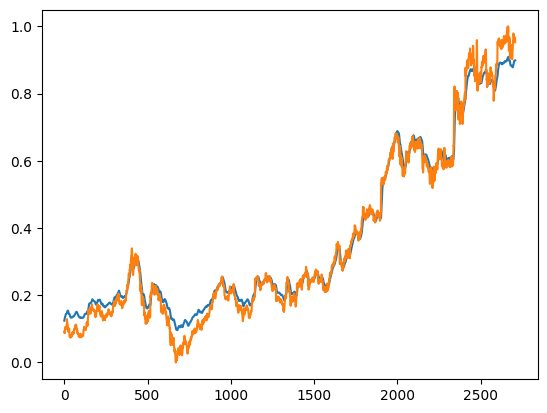

In [22]:
train_preds = model(x_train_tensor).detach().numpy()
plt.plot(train_preds)
plt.plot(y_train);

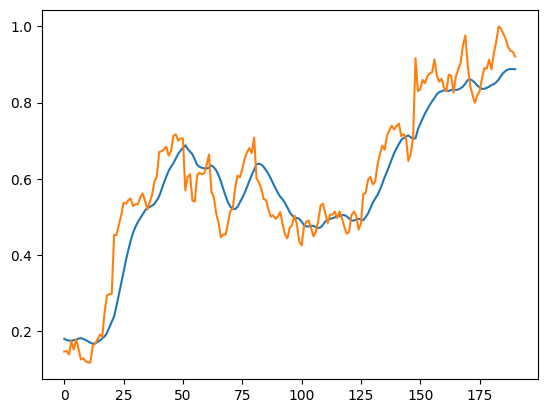

In [23]:
y_preds = model(x_val_tensor).detach().numpy()
plt.plot(y_preds)
plt.plot(y_val);

In [126]:
test_df = pd.read_csv('GOOGL.csv')
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[test_df['Date'] >= '2020-01-01']
test_price_df = test_df[['High']]
scaled_df = sc.fit_transform(test_price_df)
scaled_test_df = scaled_df
x_test, y_test = transform_data(scaled_test_df, num_hidden)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.Tensor)

x_test.shape =  (502, 59, 1)
y_test.shape =  (502, 1)


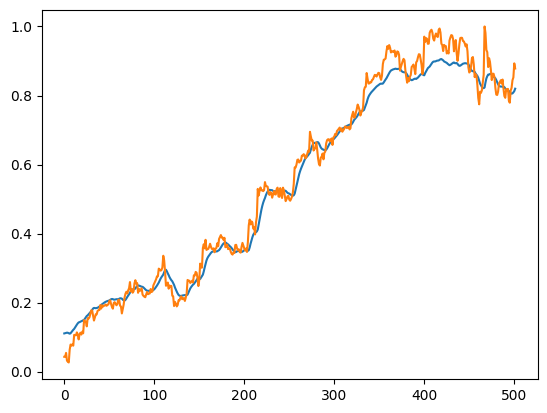

In [127]:
y_preds = model(x_test_tensor).detach().numpy()
plt.plot(y_preds)
plt.plot(y_test);

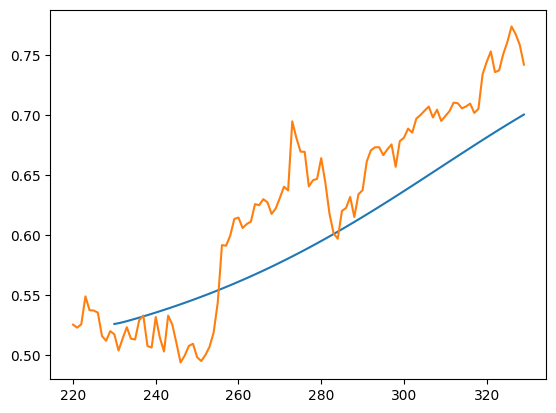

In [175]:
dias_a_predecir = 100
dia_a_predecir = 230
y_preds = []

x_test_tensor_modified = torch.unsqueeze(x_test_tensor[dia_a_predecir], dim=0)

for _ in range(dias_a_predecir):
    y_pred = model(x_test_tensor_modified)
    y_preds.append(y_pred.detach().numpy())
    
    x_test_tensor_modified = x_test_tensor_modified[:, 1:, :]

    x_test_tensor_modified = torch.cat((x_test_tensor_modified, y_pred.unsqueeze(1)), dim=1)

y_test_combined = np.squeeze(y_test[dia_a_predecir-10:dia_a_predecir+dias_a_predecir])
y_preds_combined = np.concatenate(y_preds, axis=0)
y_preds_combined = np.squeeze(y_preds_combined)
sns.lineplot(x=np.arange(dia_a_predecir, dia_a_predecir+dias_a_predecir),y=y_preds_combined, label='Predictions', legend=False)
sns.lineplot(x=np.arange(dia_a_predecir-10, dia_a_predecir+dias_a_predecir), y=y_test_combined, legend=False);